# Metadata

Model number of shootings per state given political spending by party in a given state.  

Data Sources: 

    Gun Violence Awareness  
    Political Media Spending (3rd party) from 2020 Presidential General Election

Modeling based on the following:  
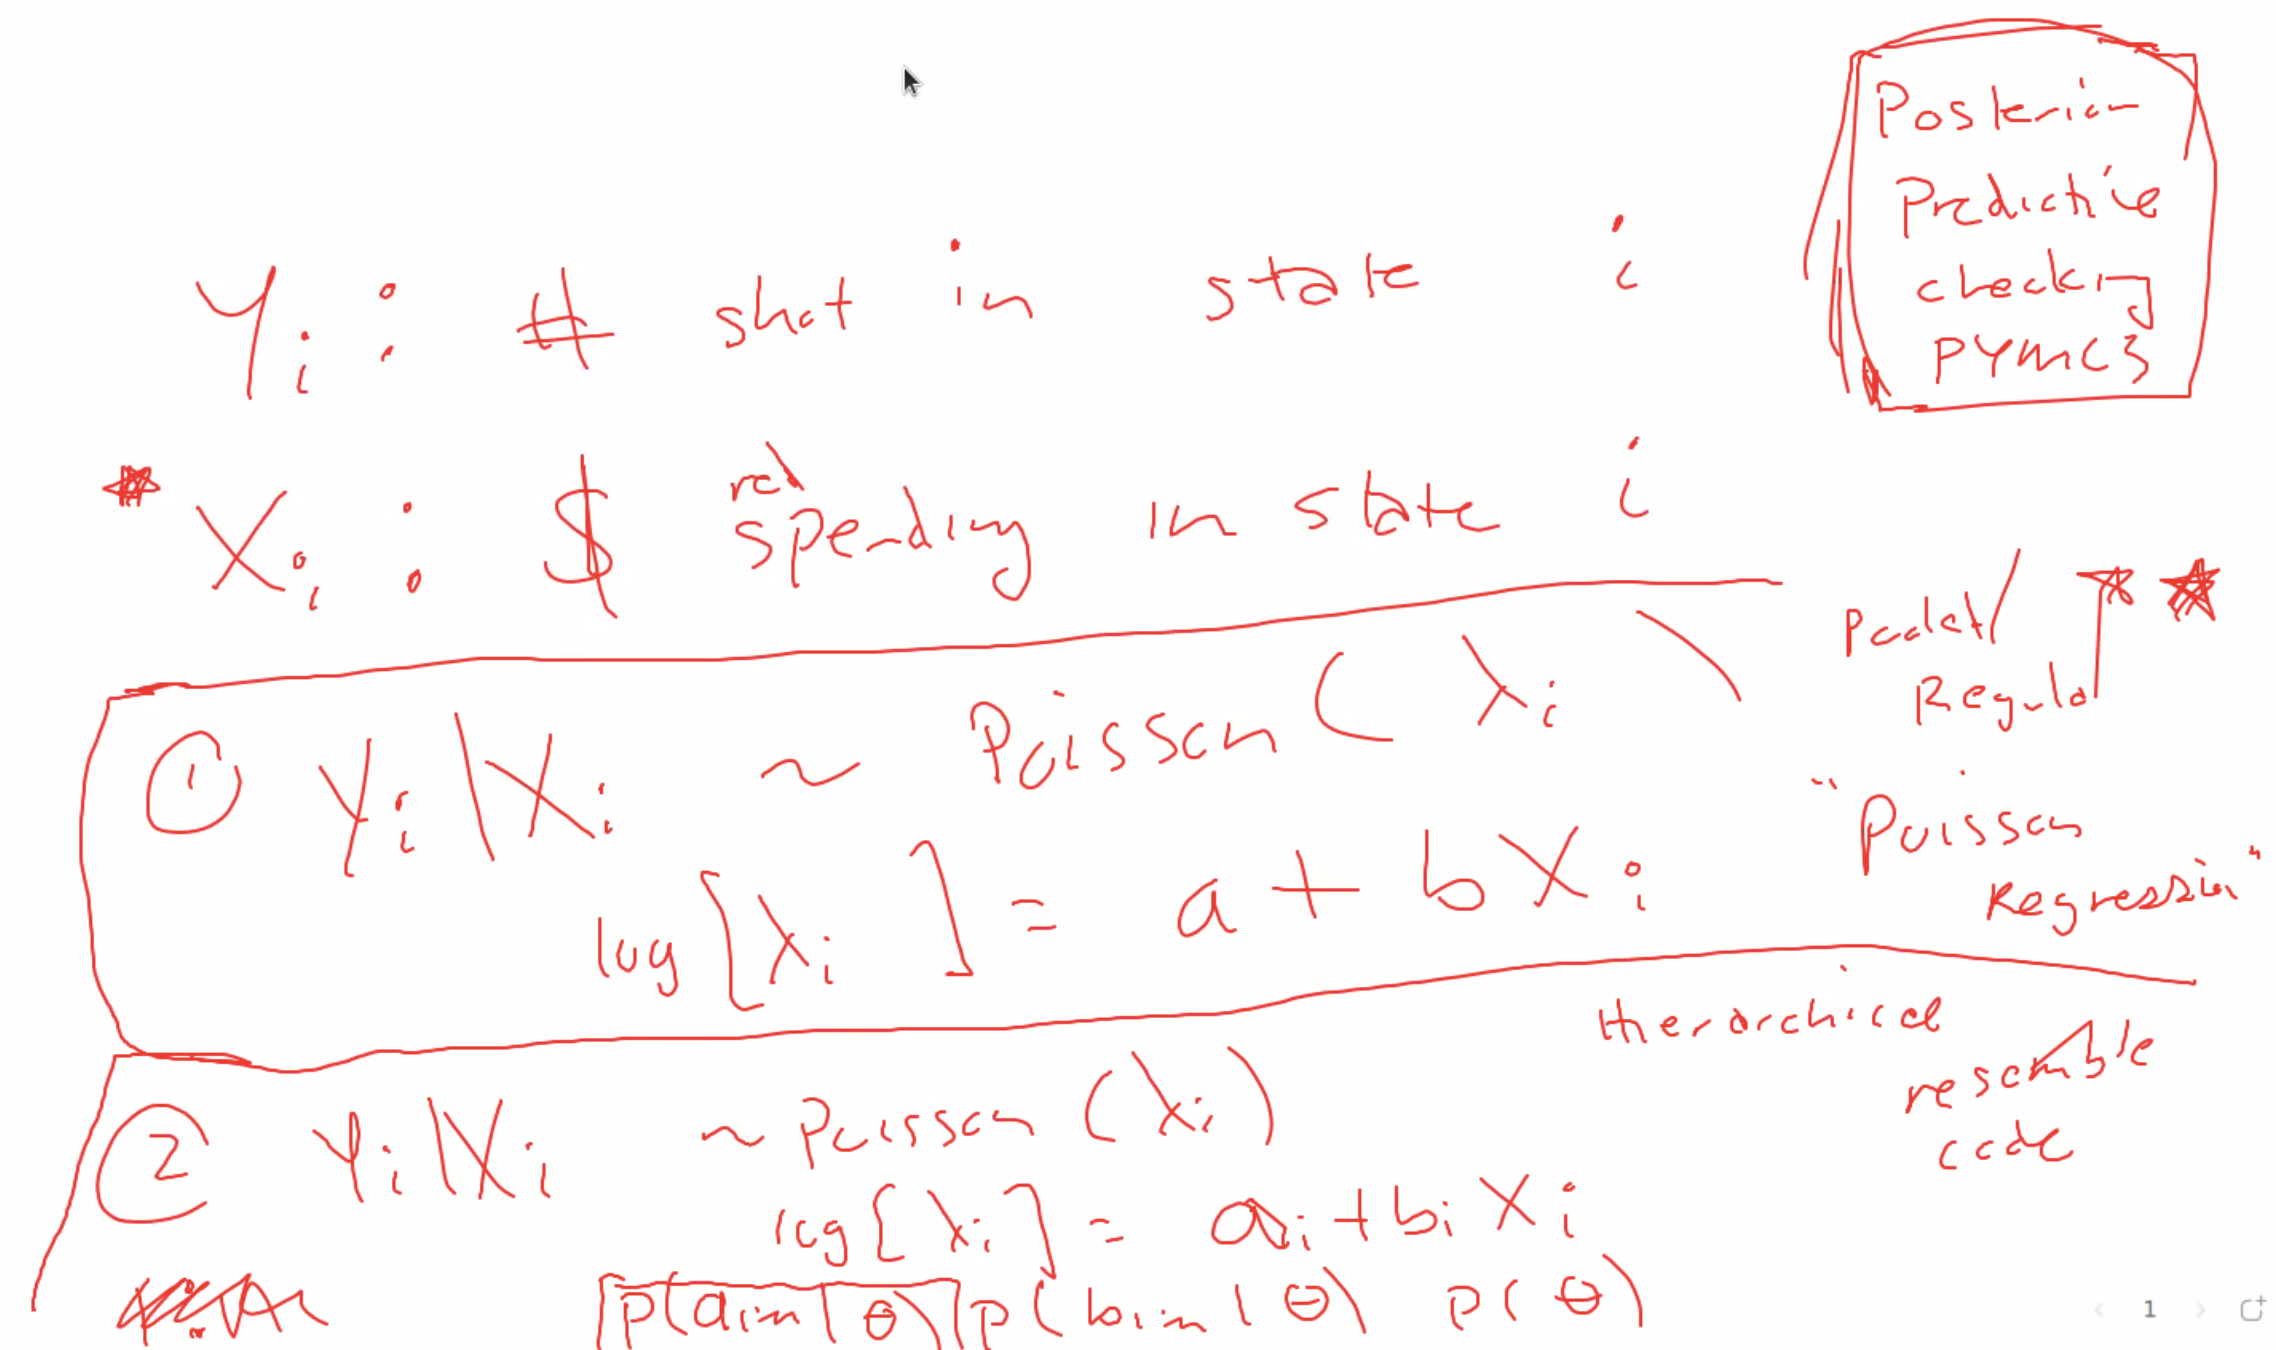

Poisson distribution is useful when counting things. In this case, we're counting the number of victims in all shootings (from 2020 to 7/8/22) for each state. Model requires using discrete non-negative numbers: {0,1,2,3...} (aka count data).

https://learning.oreilly.com/library/view/bayesian-analysis-with/9781789341652/2252e56c-3e2d-40ae-812b-38a5bd4e63d2.xhtml

https://www.youtube.com/watch?v=ZxR3mw-Znzc

Workflow:  
1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence (cool stuff?)
6. Run posterior predictive check
7. Improve model


In [1]:
#import libraries
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from formulae import design_matrices
import arviz as az
import bambi as bmb
import math

# Load data

In [2]:
df = pd.read_csv("state_level_data.csv")
party = pd.read_csv("presidential_state_results_2020.csv")

In [3]:
#df.columns

In [4]:
#party

In [5]:
#drop index column
df = df[['state', 'total_involved', 'abbrev', 'democrat','republican']]

In [6]:
#add column for red/blue state (visualization purposes only)
df = df.join(other = party.set_index('state'), on = 'abbrev', how = 'left')

In [7]:
df['log_rep'] = [np.log(x) for x in df['republican']] 

In [8]:
df['log_inv'] = [np.log(x) for x in df['total_involved']] 

In [9]:
df

,state,total_involved,abbrev,democrat,republican,party,log_rep,log_inv
0,Alabama,195,AL,3.847529e+05,1.336843e+06,r,14.105821,5.273000
1,Alaska,18,AK,9.699815e+04,2.169688e+05,r,12.287509,2.890372
2,Arizona,106,AZ,9.079025e+07,6.144790e+07,b,17.933700,4.663439
3,Arkansas,127,AR,3.368742e+05,5.981153e+05,r,13.301539,4.844187
4,California,557,CA,1.067421e+07,8.769293e+06,b,15.986767,6.322565
5,Colorado,168,CO,4.200255e+06,1.118881e+06,b,13.927840,5.123964
6,Connecticut,50,CT,5.880892e+05,3.885284e+05,b,12.870121,3.912023
7,Delaware,43,DE,2.135545e+05,1.185754e+05,b,11.683305,3.761200
8,District of Columbia,156,DC,7.453544e+06,2.962742e+06,b,14.901626,5.049856
9,Florida,413,FL,2.289976e+08,1.205918e+08,r,18.607922,6.023448


In [8]:
#save df with party info
#df.to_csv('state_spending_with_party.csv')

# 1. Plot Data

<AxesSubplot:xlabel='log_rep', ylabel='log_inv'>

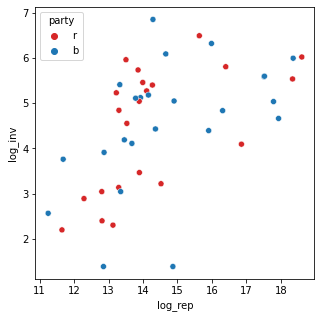

In [10]:
#define palette colors
palette = {'b':'tab:blue',
          'r':'tab:red'}

#scatterplot
plt.figure(figsize = (5,5))
sns.scatterplot(data = df, 
                x = 'log_rep', 
                y = 'log_inv',
                hue = 'party',
               palette = palette)

# #add text labels
# for i in range(df.shape[0]):
#     if df.total_involved[i] > 200:
#         plt.text(x = df.republican[i]+5,
#                 y = df.total_involved[i]+15,
#                 s = df.state[i],
#                 fontdict=dict(color = 'black', size = 10))

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

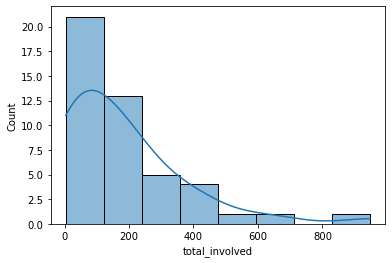

In [12]:
sns.histplot(data = df, x = 'total_involved', kde = True)

<AxesSubplot:xlabel='log_inv', ylabel='Count'>

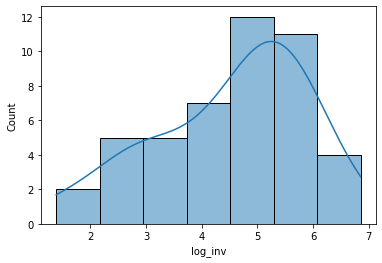

In [11]:
sns.histplot(data = df, x = 'log_inv', kde = True)

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

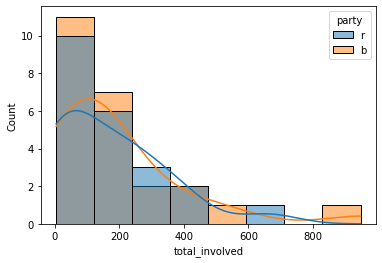

In [18]:
sns.histplot(data = df, x = 'total_involved', kde = True, hue = 'party')

<AxesSubplot:xlabel='log_inv', ylabel='Count'>

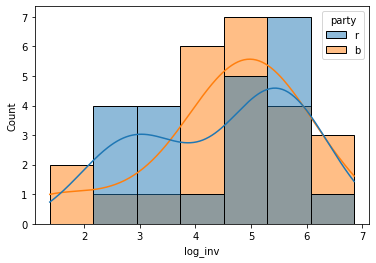

In [13]:
sns.histplot(data = df, x = 'log_inv', kde = True, hue = 'party')

# 2. Build Model

The probability mass function of Poisson distribution is as follows:  

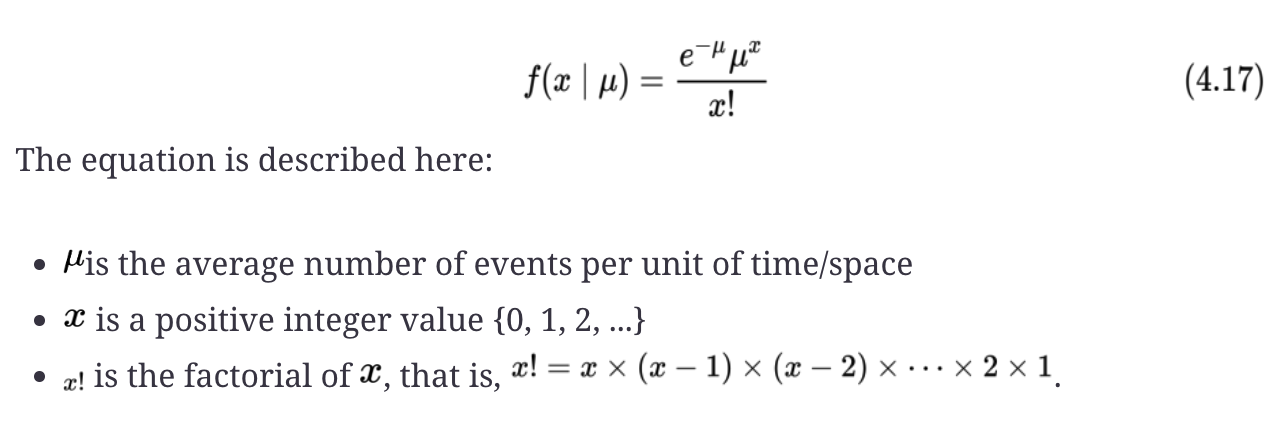

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html

In [14]:
#create model (full formulae formulation)
fml = 'log_inv ~ log_rep'

In [15]:
#create design matrices
dm = design_matrices(fml, df, na_action = 'error')

In [16]:
dm

DesignMatrices

                  (rows, cols)
Response:                (46,)
Common:                (46, 2)

Use .reponse, .common, or .group to access the different members.

In [17]:
mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

In [18]:
mx_ex.head()

,Intercept,log_rep
0,1.0,14.105821
1,1.0,12.287509
2,1.0,17.933700
3,1.0,13.301539
4,1.0,15.986767


In [19]:
mx_ex.Intercept.value_counts()

1.0    46
Name: Intercept, dtype: int64

In [20]:
mx_en.head()

,log_inv
0,5.273000
1,2.890372
2,4.663439
3,4.844187
4,6.322565


In [21]:
#create model

with pm.Model() as pois_log:
    
    #define priors
    b0 = pm.Normal("intercept", mu = 0, sigma = 10)
    b1 = pm.Normal("log_rep", mu = 0, sigma = 10)

    #define logistic model
    log_lambda = (b0 + b1*df['log_rep'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df['log_inv'].values)

In [22]:
#sample model
with pois_log:
    test = pm.sample(1000, init='adapt_diag', tune = 2000)# start= {'Intercept': np.array([0.225]), 'republican': np.array([10000000.])})

/Applications/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_rep, intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


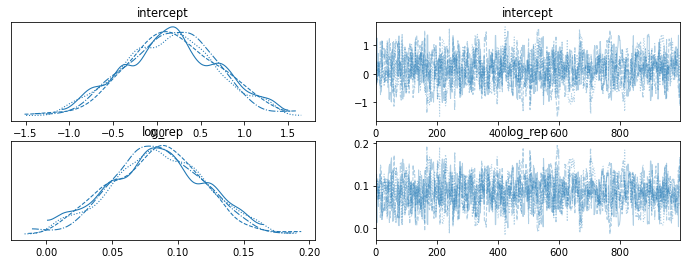

In [24]:
with pois_log:
    az.plot_trace(test)

In [26]:
#with pois_log:
az.summary(test)

Got error No model on context stack. trying to find log_likelihood in translation.
/Applications/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.165,0.531,-0.819,1.172,0.020,0.014,731.0,715.0,1.0
log_rep,0.085,0.035,0.021,0.154,0.001,0.001,727.0,766.0,1.0


## Hierarchical

https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           46 non-null     object 
 1   total_involved  46 non-null     int64  
 2   abbrev          46 non-null     object 
 3   democrat        46 non-null     float64
 4   republican      46 non-null     float64
 5   party           46 non-null     object 
 6   log_rep         46 non-null     float64
 7   log_inv         46 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.0+ KB


In [28]:
df2 = df[['party', 'log_inv', 'log_rep']]

In [30]:
df2['party'] = df2['party'].astype('category')

/var/folders/8w/lcbkp3d94ms0tyj03qhvhby40000gn/T/ipykernel_87191/3968075602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['party'] = df2['party'].astype('category')


In [31]:
df2.head()

,party,log_inv,log_rep
0,r,5.273000,14.105821
1,r,2.890372,12.287509
2,b,4.663439,17.933700
3,r,4.844187,13.301539
4,b,6.322565,15.986767


In [32]:
party_idxs, parties = pd.factorize(df2.party)
coords = {
    "party": parties,
    "obs_id": np.arange(len(party_idxs)),
}

In [33]:
# 1 -> blue (dem) 
# 0 -> red (rep)
party_idxs

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1])

In [34]:
parties

CategoricalIndex(['r', 'b'], categories=['b', 'r'], ordered=False, dtype='category')

In [35]:
coords

{'party': CategoricalIndex(['r', 'b'], categories=['b', 'r'], ordered=False, dtype='category'),
 'obs_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])}

In [45]:
with pm.Model():
    party_idx = pm.Data("party_idx", party_idxs)
    print(party_idx)

party_idx


In [102]:
with pm.Model() as hierarchical_model:
    party_idx = pm.Data("party_idx", party_idxs)
    
    # Hyperparameters for groups (states)
    #mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    #sigma_b0 = pm.HalfNormal("sigma_b0", 5.0)
    #mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    #sigma_b1 = pm.HalfNormal("sigma_b1", 5.0)
    
    mu_b0 = pm.Normal("mu_b0", mu=0.0, sigma=100)
    sigma_b0 = pm.HalfNormal("sigma_b0", 20.0)
    mu_b1 = pm.Normal("mu_b1", mu=0.0, sigma=100)
    sigma_b1 = pm.HalfNormal("sigma_b1", 20.0)

    #b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = df2.log_inv.shape)
    #b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = df2.log_inv.shape)
    b0 = pm.Normal("b0", mu=mu_b0, sigma=sigma_b0, shape = 2)
    b1 = pm.Normal("b1", mu=mu_b1, sigma=sigma_b1, shape = 2)
    
    #define logistic model
    #log_lambda = b0[party_idxs] + b1[party_idxs] * df2.log_rep.values 
    log_lambda = b0[party_idx] + b1[party_idx] * df2.log_rep.values 
        
    #Data Likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = df2.log_inv) 

In [103]:
with hierarchical_model:
        trace = pm.sample(8000, init='adapt_diag', tune = 8000, target_accept = 0.9) 

/Applications/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 4 chains for 8_000 tune and 8_000 draw iterations (32_000 + 32_000 draws total) took 65 seconds.
There were 1229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8105745266759047, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1651 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.721578548041809, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1652 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7394425805613546, but should be close to 0.9. Try to increase the number of tuning steps.
There were 1398 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7774608924335199, but should be c

Got error No model on context stack. trying to find log_likelihood in translation.
/Applications/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b0'}>],
       [<AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'mu_b1'}>],
       [<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b0'}>],
       [<AxesSubplot:title={'center':'sigma_b1'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>]], dtype=object)

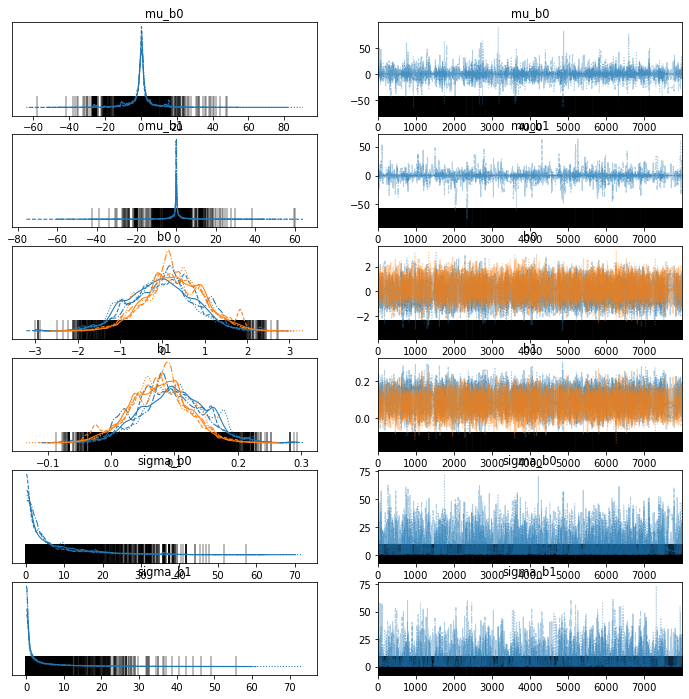

In [104]:
az.plot_trace(trace)

In [59]:
#az.plot_trace(trace, var_names=["mu_b0", "mu_b1", "sigma_b0", "sigma_b1"]);

In [41]:
pd.set_option('display.max_rows',None)

In [105]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Applications/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_b0,0.122,7.419,-13.327,15.746,0.215,0.152,1401.0,819.0,1.01
mu_b1,-0.161,6.114,-12.601,10.362,0.167,0.118,2151.0,1049.0,1.01
b0[0],0.002,0.771,-1.341,1.455,0.032,0.023,577.0,1378.0,1.01
b0[1],0.293,0.720,-1.054,1.667,0.024,0.020,890.0,446.0,1.00
b1[0],0.096,0.052,-0.001,0.190,0.002,0.002,587.0,1738.0,1.01
b1[1],0.075,0.047,-0.016,0.164,0.002,0.001,889.0,486.0,1.00
sigma_b0,6.808,8.214,0.162,22.445,0.268,0.189,426.0,227.0,1.01
sigma_b1,4.535,7.200,0.037,18.763,0.219,0.155,235.0,94.0,1.02


Got error No model on context stack. trying to find log_likelihood in translation.
/Applications/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_b0'}>,
        <AxesSubplot:title={'center':'mu_b1'}>,
        <AxesSubplot:title={'center':'b0\n0'}>,
        <AxesSubplot:title={'center':'b0\n1'}>],
       [<AxesSubplot:title={'center':'b1\n0'}>,
        <AxesSubplot:title={'center':'b1\n1'}>,
        <AxesSubplot:title={'center':'sigma_b0'}>,
        <AxesSubplot:title={'center':'sigma_b1'}>]], dtype=object)

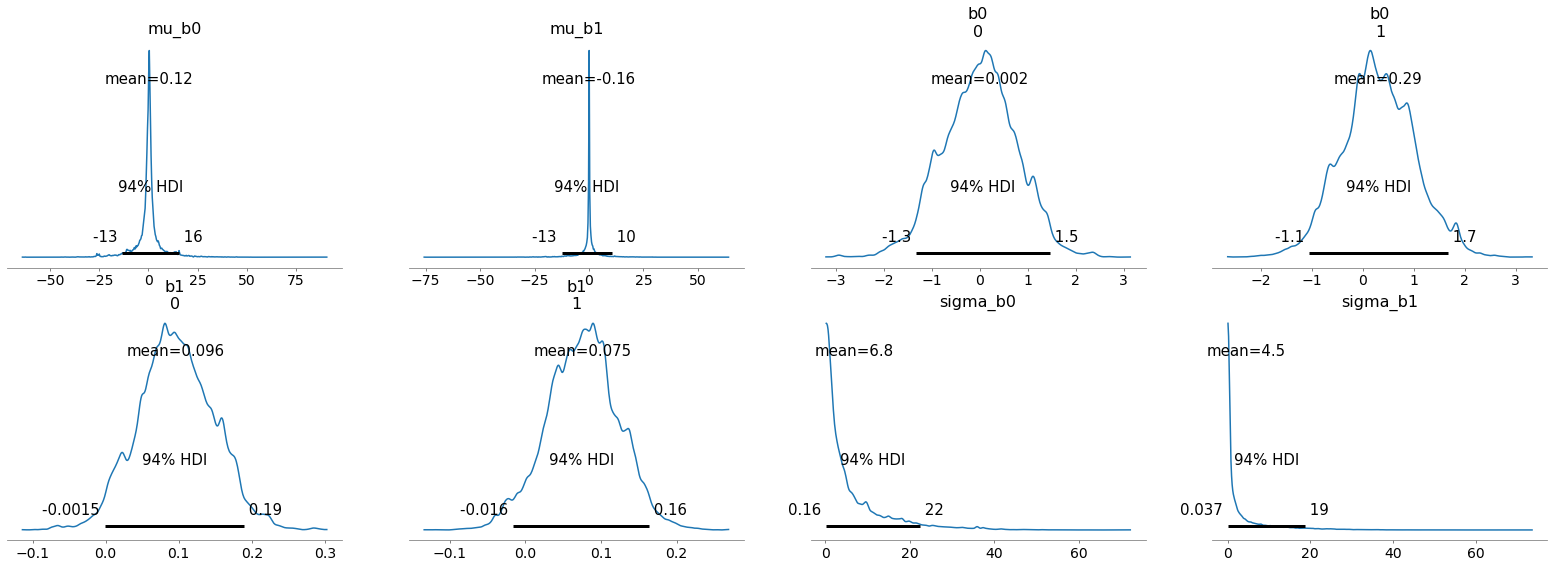

In [106]:
az.plot_posterior(trace) #var_names=["ab"])

Got error No model on context stack. trying to find log_likelihood in translation.
/Applications/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='mu_b1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b0\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b0\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b1\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b1\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma_b0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='mu_b0', ylabel='sigma_b1'>,
        <AxesSubplot:xlabel='mu_b1'>, <AxesSubplot:xlabel='b0\n0'>,
        <AxesS

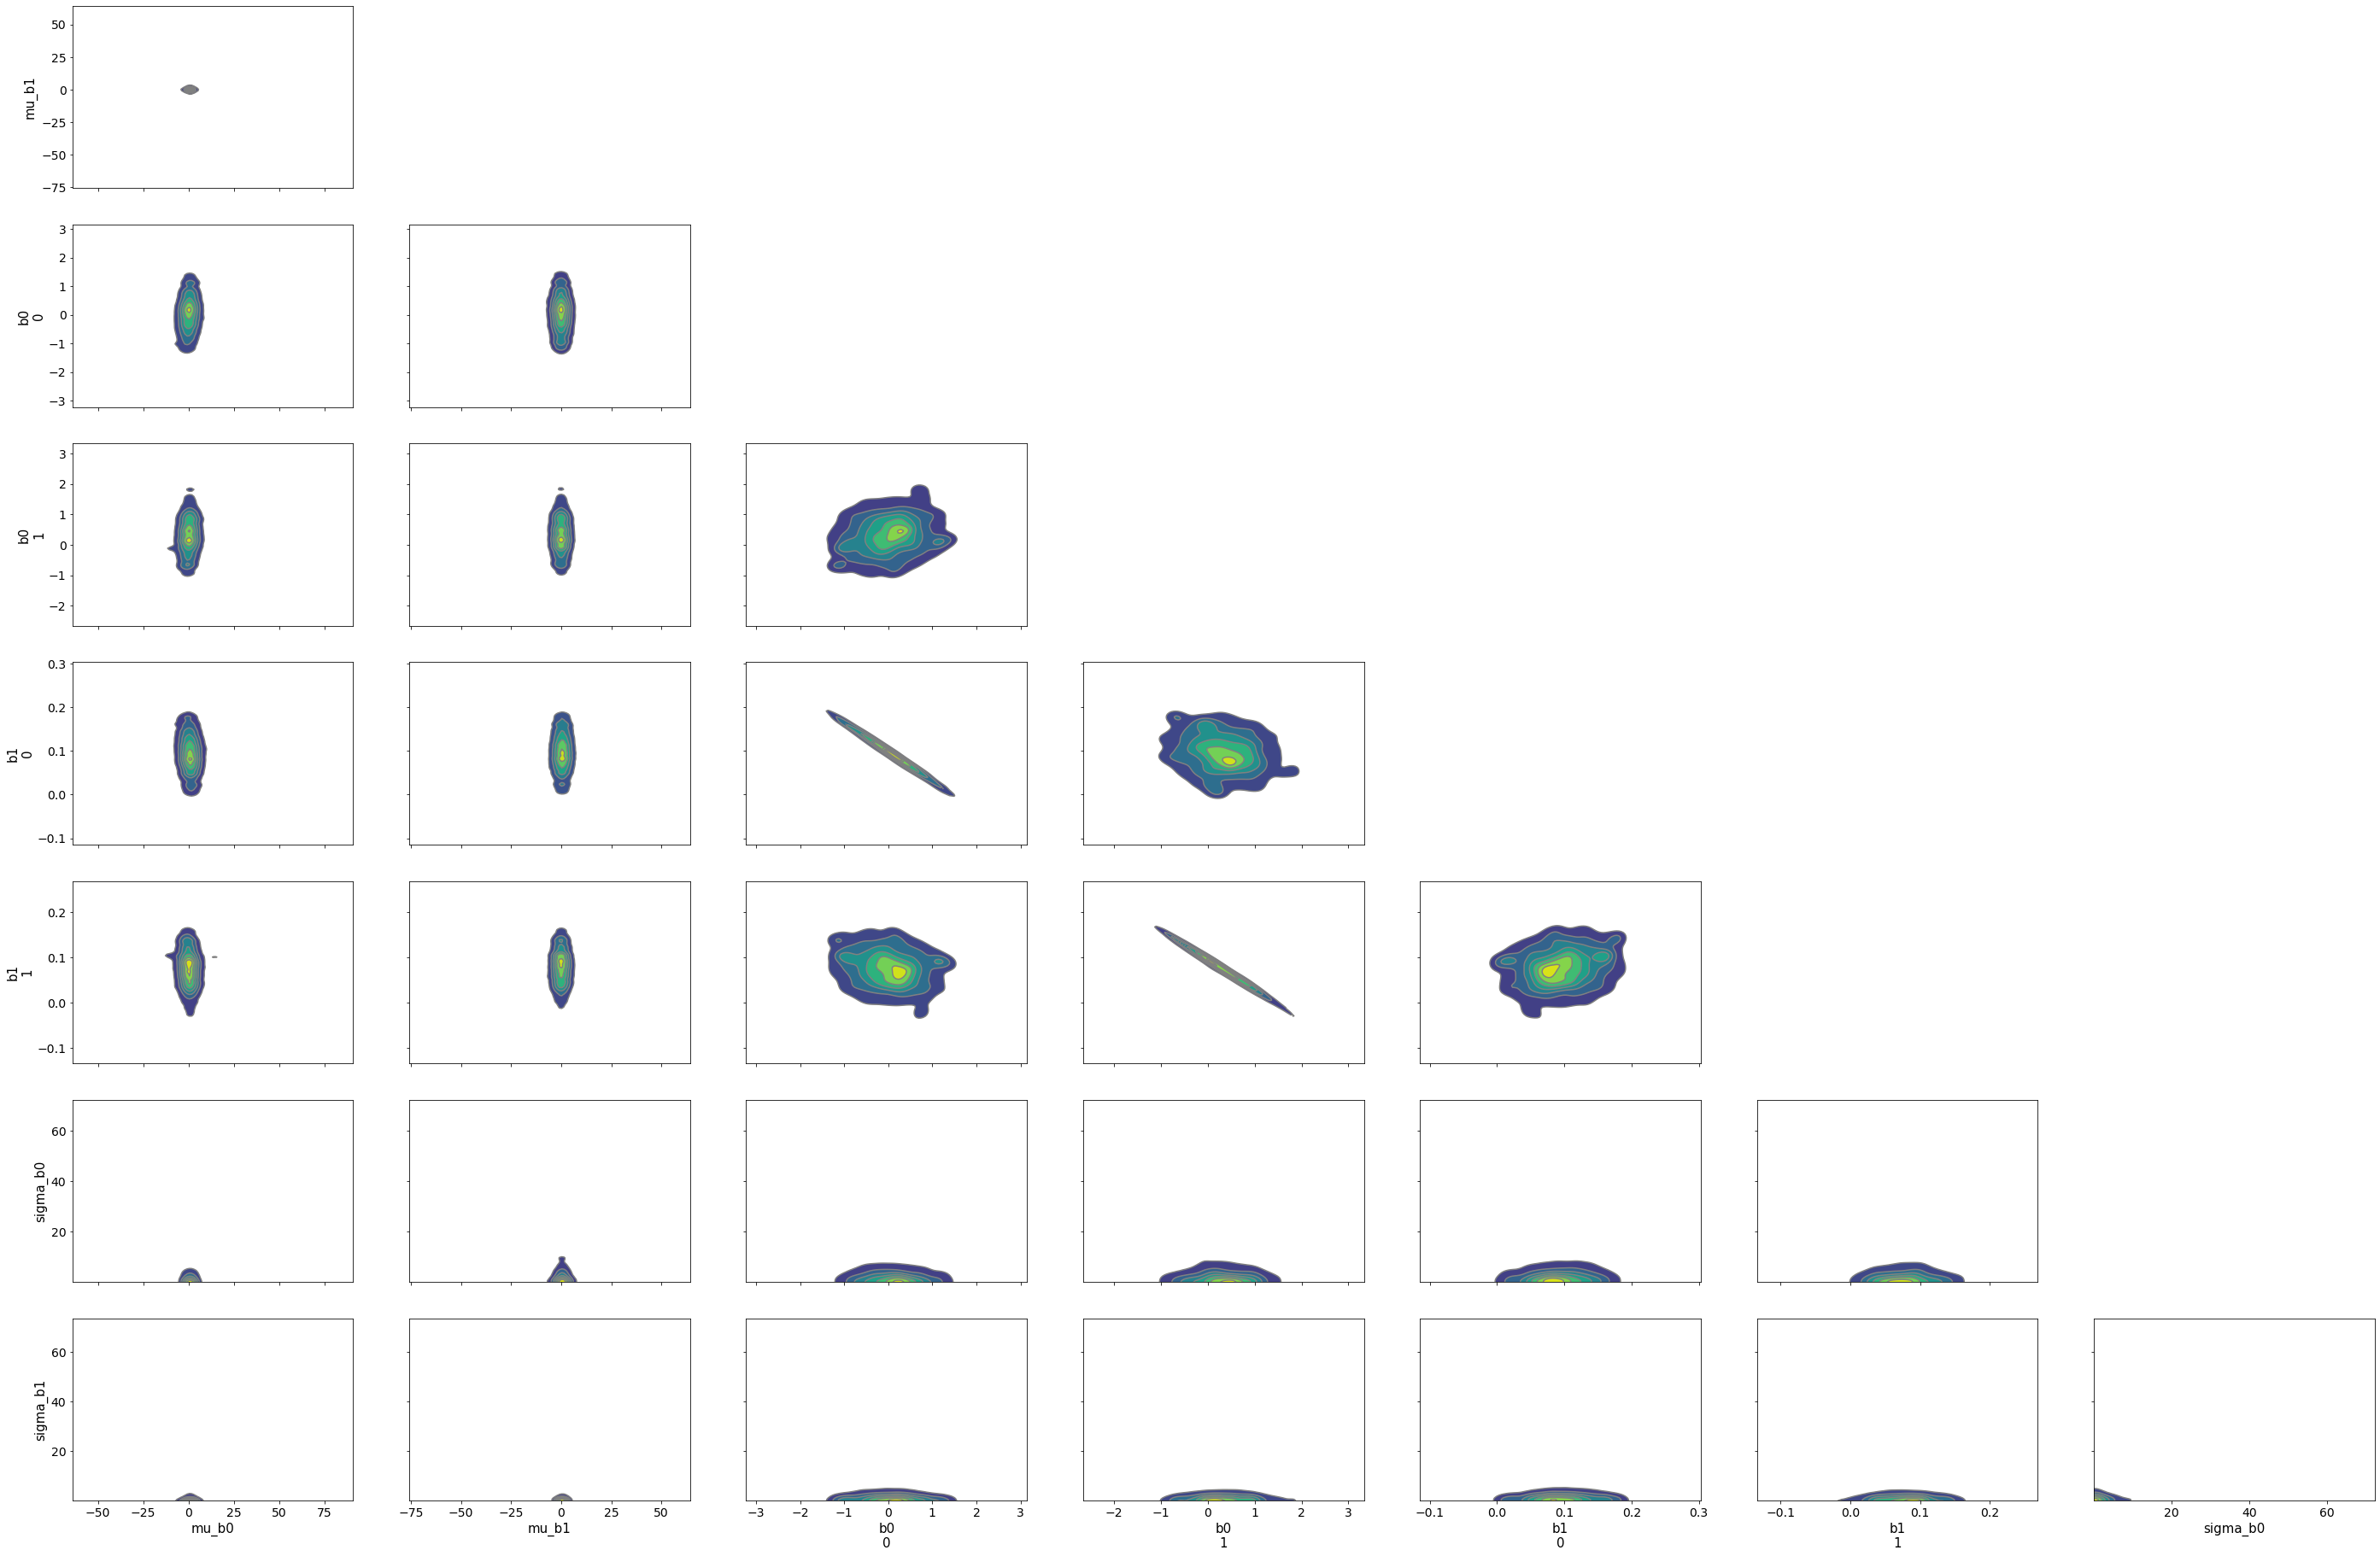

In [107]:
#az.plot_pair(trace, var_names=["X", "Z"], kind="kde")
az.plot_pair(trace, kind="kde")